In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ================================================================
# 1. 기본 설정 및 데이터 로딩
# ================================================================
print("Step 1: 기본 설정 및 데이터 로딩")

# --- 하이퍼파라미터 ---
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
DATA_DIR = '/home/nas/data/KYM/Diffusion model/CelebA Autoencoder/archive/celeba_hq_256/'
# <<< 수정됨: 가장 깊은 모델을 위한 결과 폴더 경로 변경
OUTPUT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/'
# <<< 수정 끝
IMG_SIZE = 256
FINAL_LATENT_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 350
LR = 1e-4
KL_WEIGHT = 1e-6
ADV_WEIGHT = 0.01

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'reconstructed'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'checkpoints'), exist_ok=True)


# --- 데이터셋 클래스 및 로더 ---
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, idx

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = CustomImageDataset(DATA_DIR, transform)
train_dataset = Subset(full_dataset, list(range(20000)))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print(f"Device: {DEVICE}")
print(f"학습 데이터 개수: {len(train_dataset)}")


# ================================================================
# 2. 모델 구조 정의 (수정됨)
# ================================================================
print("\nStep 2: 모델 구조 정의 (16x16 잠재 공간으로 수정)")

# --- Residual Block ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

# --- Encoder (수정됨) ---
class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=FINAL_LATENT_CHANNELS):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, 1, 1), # 256
            ResBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), # 128
            ResBlock(base_channels*2, base_channels*2),
            nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), # 64
            ResBlock(base_channels*4, base_channels*4),
            nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), # 32
            ResBlock(base_channels*8, base_channels*8),
            # <<< 수정됨: 16x16으로 가는 최종 다운샘플링 블록 추가
            nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), # 16
            ResBlock(base_channels*16, base_channels*16),
            # <<< 수정 끝
            nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

# --- Decoder (수정됨) ---
class DecoderSuperDeep(nn.Module):
    def __init__(self, out_channels=3, base_channels=128, latent_channels=FINAL_LATENT_CHANNELS):
        super().__init__()
        self.decoder = nn.Sequential(
            # <<< 수정됨: 16x16에서 시작하도록 업샘플링 블록 추가
            nn.Conv2d(latent_channels, base_channels*16, 3, 1, 1),
            ResBlock(base_channels*16, base_channels*16),
            nn.Upsample(scale_factor=2, mode='nearest'), # 16 -> 32
            nn.Conv2d(base_channels*16, base_channels*8, 3, 1, 1),
            # <<< 수정 끝
            ResBlock(base_channels*8, base_channels*8),
            nn.Upsample(scale_factor=2, mode='nearest'), # 32 -> 64
            nn.Conv2d(base_channels*8, base_channels*4, 3, 1, 1),
            ResBlock(base_channels*4, base_channels*4),
            nn.Upsample(scale_factor=2, mode='nearest'), # 64 -> 128
            nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1),
            ResBlock(base_channels*2, base_channels*2),
            nn.Upsample(scale_factor=2, mode='nearest'), # 128 -> 256
            nn.Conv2d(base_channels*2, base_channels, 3, 1, 1),
            ResBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, out_channels, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z): return self.decoder(z)

# --- Discriminator, Reparameterization Trick (이전과 동일) ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1), nn.BatchNorm2d(base_channels*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1), nn.BatchNorm2d(base_channels*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*4, base_channels*8, 4, 1, 1), nn.BatchNorm2d(base_channels*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*8, 1, 4, 1, 1)
        )
    def forward(self, img): return self.model(img)

def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

Step 1: 기본 설정 및 데이터 로딩
Device: cuda:2
학습 데이터 개수: 20000

Step 2: 모델 구조 정의 (16x16 잠재 공간으로 수정)


In [ ]:
# ================================================================
# 3. 학습 준비 및 루프 실행
# ================================================================
print("\nStep 3: 학습 준비")

DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
gpu_ids = [2, 1, 3] # 2번 GPU를 메인으로 설정
print(f"Main GPU: {DEVICE}, Parallel GPUs: {gpu_ids}")

# 가장 깊은 SuperDeep 모델 클래스 사용
encoder = nn.DataParallel(EncoderSuperDeep(), device_ids=gpu_ids).to(DEVICE)
decoder = nn.DataParallel(DecoderSuperDeep(), device_ids=gpu_ids).to(DEVICE)
discriminator = nn.DataParallel(Discriminator(), device_ids=gpu_ids).to(DEVICE)
print("수정된 모델(EncoderSuperDeep, DecoderSuperDeep)을 지정된 device_ids로 DataParallel에 감쌌습니다.")

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

recon_loss_fn = nn.L1Loss()
adv_loss_fn = nn.BCEWithLogitsLoss()

fixed_images_for_viz, _ = next(iter(train_loader))
fixed_images_for_viz = fixed_images_for_viz[:10].to(DEVICE)

# <<< 추가됨: 최저 재구성 손실을 추적하기 위한 변수 초기화
best_recon_loss = float('inf')
# <<< 추가 끝

print("학습을 시작합니다...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); discriminator.train()
    total_recon_loss, total_kl_loss, total_g_loss, total_d_loss = 0, 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for real_imgs, _ in pbar:
        real_imgs = real_imgs.to(DEVICE)

        # --- Discriminator 학습 ---
        opt_disc.zero_grad()
        mu, log_var = encoder(real_imgs)
        z = reparameterize(mu, log_var)
        fake_imgs = decoder(z)
        
        real_pred = discriminator(real_imgs)
        real_labels = torch.ones_like(real_pred)
        loss_d_real = adv_loss_fn(real_pred, real_labels)
        
        fake_pred = discriminator(fake_imgs.detach())
        fake_labels = torch.zeros_like(fake_pred)
        loss_d_fake = adv_loss_fn(fake_pred, fake_labels)
        
        loss_d = ((loss_d_real + loss_d_fake) / 2).mean()
        loss_d.backward()
        opt_disc.step()

        # --- Autoencoder 학습 ---
        opt_ae.zero_grad()
        mu, log_var = encoder(real_imgs)
        z = reparameterize(mu, log_var)
        recon_imgs = decoder(z)
        
        loss_recon = recon_loss_fn(recon_imgs, real_imgs)
        loss_kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss_g_adv = adv_loss_fn(discriminator(recon_imgs), real_labels)
        
        loss_g = (loss_recon + KL_WEIGHT * loss_kl.mean() + ADV_WEIGHT * loss_g_adv.mean()).mean()
        loss_g.backward()
        opt_ae.step()
        
        total_d_loss += loss_d.item()
        total_recon_loss += loss_recon.mean().item()
        total_kl_loss += loss_kl.mean().item()
        total_g_loss += loss_g.item()
        pbar.set_postfix({
            "Recon": f"{loss_recon.mean().item():.4f}", 
            "KL": f"{loss_kl.mean().item():.4f}", 
            "D_Loss": f"{loss_d.item():.4f}", 
            "G_Loss": f"{loss_g_adv.mean().item():.4f}"
        })

    avg_recon = total_recon_loss / len(train_loader)
    avg_kl = total_kl_loss / len(train_loader)
    avg_g = total_g_loss / len(train_loader)
    avg_d = total_d_loss / len(train_loader)
    print(f"Epoch {epoch+1} 완료 | Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, D_Loss: {avg_d:.4f}, G_Loss_Total: {avg_g:.4f}")

    with torch.no_grad():
        encoder.eval(); decoder.eval()
        mu, log_var = encoder(fixed_images_for_viz)
        z = reparameterize(mu, log_var)
        recon_samples = decoder(z)
        real_samples = (fixed_images_for_viz * 0.5) + 0.5
        recon_samples = (recon_samples * 0.5) + 0.5
        comparison = torch.cat([real_samples, recon_samples])
        save_image(comparison.cpu(), os.path.join(OUTPUT_DIR, f'reconstructed/comparison_epoch_{epoch+1:03d}.png'), nrow=10)

    # <<< 수정됨: 최저 재구성 손실을 기록할 때만 모델 저장
    if avg_recon < best_recon_loss:
        best_recon_loss = avg_recon
        torch.save(encoder.module.state_dict(), os.path.join(OUTPUT_DIR, 'checkpoints/encoder_superdeep_best.pth'))
        torch.save(decoder.module.state_dict(), os.path.join(OUTPUT_DIR, 'checkpoints/decoder_superdeep_best.pth'))
        torch.save(discriminator.module.state_dict(), os.path.join(OUTPUT_DIR, 'checkpoints/discriminator_superdeep_best.pth'))
        print(f"Epoch {epoch+1}: New best model found! Recon Loss: {best_recon_loss:.4f}. Checkpoint saved.")
    # <<< 수정 끝

print("\n학습이 모두 완료되었습니다.")


Step 3: 학습 준비
Main GPU: cuda:2, Parallel GPUs: [2, 1, 3]
수정된 모델(EncoderSuperDeep, DecoderSuperDeep)을 지정된 device_ids로 DataParallel에 감쌌습니다.
학습을 시작합니다...


Epoch 1/350:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 2/350:   0%|          | 0/313 [00:00<?, ?it/s]

In [1]:
import os

import torch

import torch.nn as nn

import torch.optim as optim

import numpy as np

from PIL import Image

from torch.utils.data import DataLoader, Dataset, Subset

from torchvision import transforms

from torchvision.utils import save_image

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# ================================================================

# 1. 기본 설정 및 데이터 로딩

# ================================================================

print("Step 1: 기본 설정 및 데이터 로딩")

# --- 하이퍼파라미터 ---

DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

DATA_DIR = '/home/nas/data/KYM/Diffusion model/CelebA Autoencoder/archive/celeba_hq_256/'

OUTPUT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/'

IMG_SIZE = 256

FINAL_LATENT_CHANNELS = 1

BATCH_SIZE = 64

EPOCHS = 250

LR = 1e-4

KL_WEIGHT = 1e-6

ADV_WEIGHT = 0.01

os.makedirs(OUTPUT_DIR, exist_ok=True)

os.makedirs(os.path.join(OUTPUT_DIR, 'reconstructed'), exist_ok=True)

os.makedirs(os.path.join(OUTPUT_DIR, 'checkpoints'), exist_ok=True)

# --- 데이터셋 클래스 및 로더 ---

class CustomImageDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])

        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):

        img = Image.open(self.paths[idx]).convert('RGB')

        if self.transform: img = self.transform(img)

        return img, idx

transform = transforms.Compose([

    transforms.Resize((IMG_SIZE, IMG_SIZE)),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.5], std=[0.5])

])

full_dataset = CustomImageDataset(DATA_DIR, transform)

train_dataset = Subset(full_dataset, list(range(20000)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print(f"Device: {DEVICE}")

print(f"학습 데이터 개수: {len(train_dataset)}")

# ================================================================

# 2. 모델 구조 정의

# ================================================================

print("\nStep 2: 모델 구조 정의 (16x16 잠재 공간)")

class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.block = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels)

        )

        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        self.silu = nn.SiLU()

    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):

    def __init__(self, in_channels=3, base_channels=128, latent_channels=FINAL_LATENT_CHANNELS):

        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels),

            nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2),

            nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4),

            nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8),

            nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16),

            nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1)

        )

    def forward(self, x):

        x = self.encoder(x)

        mu, log_var = torch.chunk(x, 2, dim=1)

        return mu, log_var

class DecoderSuperDeep(nn.Module):

    def __init__(self, out_channels=3, base_channels=128, latent_channels=FINAL_LATENT_CHANNELS):

        super().__init__()

        self.decoder = nn.Sequential(

            nn.Conv2d(latent_channels, base_channels*16, 3, 1, 1), ResBlock(base_channels*16, base_channels*16),

            nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*16, base_channels*8, 3, 1, 1),

            ResBlock(base_channels*8, base_channels*8), nn.Upsample(scale_factor=2, mode='nearest'),

            nn.Conv2d(base_channels*8, base_channels*4, 3, 1, 1), ResBlock(base_channels*4, base_channels*4),

            nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1),

            ResBlock(base_channels*2, base_channels*2), nn.Upsample(scale_factor=2, mode='nearest'),

            nn.Conv2d(base_channels*2, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels),

            nn.Conv2d(base_channels, out_channels, 3, 1, 1), nn.Tanh()

        )

    def forward(self, z): return self.decoder(z)

class Discriminator(nn.Module):

    def __init__(self, in_channels=3, base_channels=64):

        super().__init__()

        self.model = nn.Sequential(

            nn.Conv2d(in_channels, base_channels, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1), nn.BatchNorm2d(base_channels*2), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1), nn.BatchNorm2d(base_channels*4), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels*4, base_channels*8, 4, 1, 1), nn.BatchNorm2d(base_channels*8), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels*8, 1, 4, 1, 1)

        )

    def forward(self, img): return self.model(img)

def reparameterize(mu, log_var):

    std = torch.exp(0.5 * log_var)

    eps = torch.randn_like(std)

    return mu + eps * std

# ================================================================

# 3. 학습 준비 및 루프 실행

# ================================================================

print("\nStep 3: 학습 준비")

DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

gpu_ids = [2, 1, 3]

print(f"Main GPU: {DEVICE}, Parallel GPUs: {gpu_ids}")

encoder = nn.DataParallel(EncoderSuperDeep(), device_ids=gpu_ids).to(DEVICE)

decoder = nn.DataParallel(DecoderSuperDeep(), device_ids=gpu_ids).to(DEVICE)

discriminator = nn.DataParallel(Discriminator(), device_ids=gpu_ids).to(DEVICE)

# <<< 추가됨: 개별 체크포인트 파일 경로 정의 >>>

CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')

ENCODER_PATH = os.path.join(CHECKPOINT_DIR, 'encoder_superdeep_best.pth')

DECODER_PATH = os.path.join(CHECKPOINT_DIR, 'decoder_superdeep_best.pth')

DISCRIMINATOR_PATH = os.path.join(CHECKPOINT_DIR, 'discriminator_superdeep_best.pth')

# --- 체크포인트 로드 (개별 파일 방식) ---

if os.path.exists(ENCODER_PATH):

    print(f"저장된 개별 체크포인트를 발견했습니다. 모델 가중치를 불러옵니다.")

    try:

        encoder.module.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))

        decoder.module.load_state_dict(torch.load(DECODER_PATH, map_location=DEVICE))

        discriminator.module.load_state_dict(torch.load(DISCRIMINATOR_PATH, map_location=DEVICE))

        print("모델 가중치를 성공적으로 불러왔습니다. 이어서 학습합니다.")

    except Exception as e:

        print(f"체크포인트 로드 중 오류 발생: {e}. 처음부터 학습을 시작합니다.")

else:

    print("저장된 체크포인트가 없습니다. 처음부터 학습을 시작합니다.")

# <<< 수정 끝 >>>

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR, betas=(0.5, 0.999))

opt_disc = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

recon_loss_fn = nn.L1Loss()

adv_loss_fn = nn.BCEWithLogitsLoss()

fixed_images_for_viz, _ = next(iter(train_loader))

fixed_images_for_viz = fixed_images_for_viz[:10].to(DEVICE)

best_recon_loss = float('inf')

print("학습을 시작합니다...")

for epoch in range(EPOCHS):

    encoder.train(); decoder.train(); discriminator.train()

    total_recon_loss, total_kl_loss, total_g_loss, total_d_loss = 0, 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for real_imgs, _ in pbar:

        real_imgs = real_imgs.to(DEVICE)

        # --- Discriminator 학습 ---

        opt_disc.zero_grad()

        mu, log_var = encoder(real_imgs)

        z = reparameterize(mu, log_var)

        fake_imgs = decoder(z)

        loss_d_real = adv_loss_fn(discriminator(real_imgs), torch.ones_like(discriminator(real_imgs)))

        loss_d_fake = adv_loss_fn(discriminator(fake_imgs.detach()), torch.zeros_like(discriminator(fake_imgs.detach())))

        loss_d = ((loss_d_real + loss_d_fake) / 2).mean()

        loss_d.backward()

        opt_disc.step()

        # --- Autoencoder 학습 ---

        opt_ae.zero_grad()

        mu, log_var = encoder(real_imgs)

        z = reparameterize(mu, log_var)

        recon_imgs = decoder(z)

        loss_recon = recon_loss_fn(recon_imgs, real_imgs)

        loss_kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        loss_g_adv = adv_loss_fn(discriminator(recon_imgs), torch.ones_like(discriminator(recon_imgs)))

        loss_g = (loss_recon + KL_WEIGHT * loss_kl.mean() + ADV_WEIGHT * loss_g_adv.mean()).mean()

        loss_g.backward()

        opt_ae.step()

        

        # 손실 값 기록

        total_d_loss += loss_d.item()

        total_recon_loss += loss_recon.mean().item()

        total_kl_loss += loss_kl.mean().item()

        total_g_loss += loss_g.item()

        pbar.set_postfix({

            "Recon": f"{loss_recon.mean().item():.4f}", 

            "KL": f"{loss_kl.mean().item():.4f}", 

            "D_Loss": f"{loss_d.item():.4f}", 

            "G_Loss": f"{loss_g_adv.mean().item():.4f}"

        })

    avg_recon = total_recon_loss / len(train_loader)

    avg_kl = total_kl_loss / len(train_loader)

    avg_g = total_g_loss / len(train_loader)

    avg_d = total_d_loss / len(train_loader)

    print(f"Epoch {epoch+1} 완료 | Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, D_Loss: {avg_d:.4f}, G_Loss_Total: {avg_g:.4f}")

    # 시각화 결과 저장

    with torch.no_grad():

        encoder.eval(); decoder.eval()

        mu, log_var = encoder(fixed_images_for_viz)

        z = reparameterize(mu, log_var)

        recon_samples = decoder(z)

        real_samples = (fixed_images_for_viz * 0.5) + 0.5

        recon_samples = (recon_samples * 0.5) + 0.5

        comparison = torch.cat([real_samples, recon_samples])

        save_image(comparison.cpu(), os.path.join(OUTPUT_DIR, f'reconstructed/comparison_epoch_{epoch+1:03d}.png'), nrow=10)

    # <<< 수정됨: 개별 파일 저장 방식으로 변경 >>>

    if avg_recon < best_recon_loss:

        best_recon_loss = avg_recon

        torch.save(encoder.module.state_dict(), ENCODER_PATH)

        torch.save(decoder.module.state_dict(), DECODER_PATH)

        torch.save(discriminator.module.state_dict(), DISCRIMINATOR_PATH)

        print(f"Epoch {epoch+1}: New best model found! Recon Loss: {best_recon_loss:.4f}. Checkpoint saved.")

    # <<< 수정 끝 >>>

print("\n학습이 모두 완료되었습니다.")



Step 1: 기본 설정 및 데이터 로딩
Device: cuda:2
학습 데이터 개수: 20000

Step 2: 모델 구조 정의 (16x16 잠재 공간)

Step 3: 학습 준비
Main GPU: cuda:2, Parallel GPUs: [2, 1, 3]
저장된 개별 체크포인트를 발견했습니다. 모델 가중치를 불러옵니다.
모델 가중치를 성공적으로 불러왔습니다. 이어서 학습합니다.
학습을 시작합니다...


Epoch 1/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 완료 | Recon: 0.2045, KL: 38284.0495, D_Loss: 0.5628, G_Loss_Total: 0.2557
Epoch 1: New best model found! Recon Loss: 0.2045. Checkpoint saved.


Epoch 2/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 완료 | Recon: 0.1936, KL: 109935.4620, D_Loss: 0.5366, G_Loss_Total: 0.3165
Epoch 2: New best model found! Recon Loss: 0.1936. Checkpoint saved.


Epoch 3/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 완료 | Recon: 0.1521, KL: 26760.2673, D_Loss: 0.5994, G_Loss_Total: 0.1895
Epoch 3: New best model found! Recon Loss: 0.1521. Checkpoint saved.


Epoch 4/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 완료 | Recon: 0.1446, KL: 27078.6969, D_Loss: 0.5915, G_Loss_Total: 0.1815
Epoch 4: New best model found! Recon Loss: 0.1446. Checkpoint saved.


Epoch 5/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 완료 | Recon: 0.1408, KL: 27220.3980, D_Loss: 0.6061, G_Loss_Total: 0.1778
Epoch 5: New best model found! Recon Loss: 0.1408. Checkpoint saved.


Epoch 6/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 완료 | Recon: 0.1372, KL: 27328.0158, D_Loss: 0.6264, G_Loss_Total: 0.1743
Epoch 6: New best model found! Recon Loss: 0.1372. Checkpoint saved.


Epoch 7/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 완료 | Recon: 0.1352, KL: 27466.2539, D_Loss: 0.6222, G_Loss_Total: 0.1724
Epoch 7: New best model found! Recon Loss: 0.1352. Checkpoint saved.


Epoch 8/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 완료 | Recon: 0.1342, KL: 27468.7197, D_Loss: 0.6095, G_Loss_Total: 0.1710
Epoch 8: New best model found! Recon Loss: 0.1342. Checkpoint saved.


Epoch 9/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 완료 | Recon: 0.1324, KL: 27570.6156, D_Loss: 0.6218, G_Loss_Total: 0.1695
Epoch 9: New best model found! Recon Loss: 0.1324. Checkpoint saved.


Epoch 10/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 완료 | Recon: 0.1313, KL: 27633.8585, D_Loss: 0.6147, G_Loss_Total: 0.1684
Epoch 10: New best model found! Recon Loss: 0.1313. Checkpoint saved.


Epoch 11/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 완료 | Recon: 0.1293, KL: 27720.5276, D_Loss: 0.6253, G_Loss_Total: 0.1666
Epoch 11: New best model found! Recon Loss: 0.1293. Checkpoint saved.


Epoch 12/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 완료 | Recon: 0.1292, KL: 27725.6752, D_Loss: 0.6199, G_Loss_Total: 0.1663
Epoch 12: New best model found! Recon Loss: 0.1292. Checkpoint saved.


Epoch 13/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 13 완료 | Recon: 0.1280, KL: 27796.3735, D_Loss: 0.6183, G_Loss_Total: 0.1652
Epoch 13: New best model found! Recon Loss: 0.1280. Checkpoint saved.


Epoch 14/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 완료 | Recon: 0.1264, KL: 27896.2426, D_Loss: 0.6427, G_Loss_Total: 0.1639
Epoch 14: New best model found! Recon Loss: 0.1264. Checkpoint saved.


Epoch 15/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 완료 | Recon: 0.1253, KL: 28000.2397, D_Loss: 0.6462, G_Loss_Total: 0.1628
Epoch 15: New best model found! Recon Loss: 0.1253. Checkpoint saved.


Epoch 16/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 완료 | Recon: 0.1245, KL: 28039.1782, D_Loss: 0.6106, G_Loss_Total: 0.1615
Epoch 16: New best model found! Recon Loss: 0.1245. Checkpoint saved.


Epoch 17/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 완료 | Recon: 0.1241, KL: 28079.1111, D_Loss: 0.6223, G_Loss_Total: 0.1612
Epoch 17: New best model found! Recon Loss: 0.1241. Checkpoint saved.


Epoch 18/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 완료 | Recon: 0.1229, KL: 28169.3753, D_Loss: 0.6232, G_Loss_Total: 0.1602
Epoch 18: New best model found! Recon Loss: 0.1229. Checkpoint saved.


Epoch 19/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 19 완료 | Recon: 0.1206, KL: 28311.6858, D_Loss: 0.6706, G_Loss_Total: 0.1586
Epoch 19: New best model found! Recon Loss: 0.1206. Checkpoint saved.


Epoch 20/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 완료 | Recon: 0.1209, KL: 28263.9654, D_Loss: 0.6197, G_Loss_Total: 0.1580


Epoch 21/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 완료 | Recon: 0.1208, KL: 28308.0214, D_Loss: 0.6257, G_Loss_Total: 0.1581


Epoch 22/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 완료 | Recon: 0.1195, KL: 28438.7294, D_Loss: 0.6574, G_Loss_Total: 0.1574
Epoch 22: New best model found! Recon Loss: 0.1195. Checkpoint saved.


Epoch 23/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 완료 | Recon: 0.1173, KL: 28554.0652, D_Loss: 0.6329, G_Loss_Total: 0.1547
Epoch 23: New best model found! Recon Loss: 0.1173. Checkpoint saved.


Epoch 24/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 완료 | Recon: 0.1179, KL: 28544.6316, D_Loss: 0.6250, G_Loss_Total: 0.1553


Epoch 25/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 완료 | Recon: 0.1171, KL: 28619.3636, D_Loss: 0.6281, G_Loss_Total: 0.1547
Epoch 25: New best model found! Recon Loss: 0.1171. Checkpoint saved.


Epoch 26/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 완료 | Recon: 0.1160, KL: 28641.9544, D_Loss: 0.6635, G_Loss_Total: 0.1540
Epoch 26: New best model found! Recon Loss: 0.1160. Checkpoint saved.


Epoch 27/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 완료 | Recon: 0.1159, KL: 28687.7155, D_Loss: 0.6244, G_Loss_Total: 0.1533
Epoch 27: New best model found! Recon Loss: 0.1159. Checkpoint saved.


Epoch 28/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 완료 | Recon: 0.1151, KL: 28763.4257, D_Loss: 0.6604, G_Loss_Total: 0.1533
Epoch 28: New best model found! Recon Loss: 0.1151. Checkpoint saved.


Epoch 29/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 완료 | Recon: 0.1127, KL: 28882.6847, D_Loss: 0.6470, G_Loss_Total: 0.1504
Epoch 29: New best model found! Recon Loss: 0.1127. Checkpoint saved.


Epoch 30/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 완료 | Recon: 0.1133, KL: 28883.3950, D_Loss: 0.6257, G_Loss_Total: 0.1509


Epoch 31/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 완료 | Recon: 0.1128, KL: 28934.6259, D_Loss: 0.6286, G_Loss_Total: 0.1506


Epoch 32/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 완료 | Recon: 0.1114, KL: 29012.1585, D_Loss: 0.6707, G_Loss_Total: 0.1498
Epoch 32: New best model found! Recon Loss: 0.1114. Checkpoint saved.


Epoch 33/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 완료 | Recon: 0.1114, KL: 29053.1693, D_Loss: 0.6255, G_Loss_Total: 0.1491
Epoch 33: New best model found! Recon Loss: 0.1114. Checkpoint saved.


Epoch 34/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 완료 | Recon: 0.1111, KL: 29107.1696, D_Loss: 0.6286, G_Loss_Total: 0.1491
Epoch 34: New best model found! Recon Loss: 0.1111. Checkpoint saved.


Epoch 35/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 완료 | Recon: 0.1102, KL: 29154.1283, D_Loss: 0.6267, G_Loss_Total: 0.1483
Epoch 35: New best model found! Recon Loss: 0.1102. Checkpoint saved.


Epoch 36/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 완료 | Recon: 0.1086, KL: 29195.1625, D_Loss: 0.6971, G_Loss_Total: 0.1473
Epoch 36: New best model found! Recon Loss: 0.1086. Checkpoint saved.


Epoch 37/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 완료 | Recon: 0.1088, KL: 29253.0851, D_Loss: 0.6226, G_Loss_Total: 0.1466


Epoch 38/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 완료 | Recon: 0.1085, KL: 29296.0908, D_Loss: 0.6249, G_Loss_Total: 0.1465
Epoch 38: New best model found! Recon Loss: 0.1085. Checkpoint saved.


Epoch 39/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 완료 | Recon: 0.1079, KL: 29385.4163, D_Loss: 0.6284, G_Loss_Total: 0.1462
Epoch 39: New best model found! Recon Loss: 0.1079. Checkpoint saved.


Epoch 40/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 완료 | Recon: 0.1073, KL: 29393.9851, D_Loss: 0.6267, G_Loss_Total: 0.1457
Epoch 40: New best model found! Recon Loss: 0.1073. Checkpoint saved.


Epoch 41/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 완료 | Recon: 0.1055, KL: 29469.4240, D_Loss: 0.7072, G_Loss_Total: 0.1445
Epoch 41: New best model found! Recon Loss: 0.1055. Checkpoint saved.


Epoch 42/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 완료 | Recon: 0.1060, KL: 29513.8579, D_Loss: 0.6198, G_Loss_Total: 0.1441


Epoch 43/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 완료 | Recon: 0.1054, KL: 29577.3767, D_Loss: 0.6236, G_Loss_Total: 0.1438
Epoch 43: New best model found! Recon Loss: 0.1054. Checkpoint saved.


Epoch 44/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 완료 | Recon: 0.1051, KL: 29611.6110, D_Loss: 0.6252, G_Loss_Total: 0.1436
Epoch 44: New best model found! Recon Loss: 0.1051. Checkpoint saved.


Epoch 45/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 완료 | Recon: 0.1044, KL: 29629.1887, D_Loss: 0.6709, G_Loss_Total: 0.1434
Epoch 45: New best model found! Recon Loss: 0.1044. Checkpoint saved.


Epoch 46/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 완료 | Recon: 0.1041, KL: 29702.1161, D_Loss: 0.6201, G_Loss_Total: 0.1424
Epoch 46: New best model found! Recon Loss: 0.1041. Checkpoint saved.


Epoch 47/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47 완료 | Recon: 0.1038, KL: 29738.4070, D_Loss: 0.6227, G_Loss_Total: 0.1425
Epoch 47: New best model found! Recon Loss: 0.1038. Checkpoint saved.


Epoch 48/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48 완료 | Recon: 0.1030, KL: 29809.0040, D_Loss: 0.6236, G_Loss_Total: 0.1417
Epoch 48: New best model found! Recon Loss: 0.1030. Checkpoint saved.


Epoch 49/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49 완료 | Recon: 0.1016, KL: 29840.6635, D_Loss: 0.7172, G_Loss_Total: 0.1414
Epoch 49: New best model found! Recon Loss: 0.1016. Checkpoint saved.


Epoch 50/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50 완료 | Recon: 0.1010, KL: 29941.9157, D_Loss: 0.6265, G_Loss_Total: 0.1392
Epoch 50: New best model found! Recon Loss: 0.1010. Checkpoint saved.


Epoch 51/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 51 완료 | Recon: 0.1016, KL: 29956.9614, D_Loss: 0.6176, G_Loss_Total: 0.1403


Epoch 52/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 52 완료 | Recon: 0.1011, KL: 29981.3755, D_Loss: 0.6203, G_Loss_Total: 0.1399


Epoch 53/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 53 완료 | Recon: 0.1007, KL: 30042.5950, D_Loss: 0.6218, G_Loss_Total: 0.1397
Epoch 53: New best model found! Recon Loss: 0.1007. Checkpoint saved.


Epoch 54/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 54 완료 | Recon: 0.0997, KL: 30072.0716, D_Loss: 0.6690, G_Loss_Total: 0.1392
Epoch 54: New best model found! Recon Loss: 0.0997. Checkpoint saved.


Epoch 55/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 55 완료 | Recon: 0.0999, KL: 30097.7471, D_Loss: 0.6162, G_Loss_Total: 0.1388


Epoch 56/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 56 완료 | Recon: 0.0994, KL: 30159.1679, D_Loss: 0.6179, G_Loss_Total: 0.1386
Epoch 56: New best model found! Recon Loss: 0.0994. Checkpoint saved.


Epoch 57/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 57 완료 | Recon: 0.0972, KL: 30225.6263, D_Loss: 0.7282, G_Loss_Total: 0.1370
Epoch 57: New best model found! Recon Loss: 0.0972. Checkpoint saved.


Epoch 58/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 58 완료 | Recon: 0.0980, KL: 30249.3935, D_Loss: 0.6154, G_Loss_Total: 0.1368


Epoch 59/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 59 완료 | Recon: 0.0982, KL: 30288.8178, D_Loss: 0.6151, G_Loss_Total: 0.1373


Epoch 60/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 60 완료 | Recon: 0.0978, KL: 30347.5929, D_Loss: 0.6185, G_Loss_Total: 0.1371


Epoch 61/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 61 완료 | Recon: 0.0967, KL: 30405.0473, D_Loss: 0.7137, G_Loss_Total: 0.1371
Epoch 61: New best model found! Recon Loss: 0.0967. Checkpoint saved.


Epoch 62/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 62 완료 | Recon: 0.0957, KL: 30402.7391, D_Loss: 0.6270, G_Loss_Total: 0.1345
Epoch 62: New best model found! Recon Loss: 0.0957. Checkpoint saved.


Epoch 63/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 63 완료 | Recon: 0.0964, KL: 30477.6779, D_Loss: 0.6144, G_Loss_Total: 0.1356


Epoch 64/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 64 완료 | Recon: 0.0956, KL: 30500.7088, D_Loss: 0.6433, G_Loss_Total: 0.1352
Epoch 64: New best model found! Recon Loss: 0.0956. Checkpoint saved.


Epoch 65/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65 완료 | Recon: 0.0959, KL: 30530.7195, D_Loss: 0.6161, G_Loss_Total: 0.1353


Epoch 66/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 66 완료 | Recon: 0.0954, KL: 30575.2498, D_Loss: 0.6164, G_Loss_Total: 0.1351
Epoch 66: New best model found! Recon Loss: 0.0954. Checkpoint saved.


Epoch 67/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 67 완료 | Recon: 0.0951, KL: 30637.9116, D_Loss: 0.6172, G_Loss_Total: 0.1349
Epoch 67: New best model found! Recon Loss: 0.0951. Checkpoint saved.


Epoch 68/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 68 완료 | Recon: 0.0938, KL: 30662.3697, D_Loss: 0.6934, G_Loss_Total: 0.1342
Epoch 68: New best model found! Recon Loss: 0.0938. Checkpoint saved.


Epoch 69/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 69 완료 | Recon: 0.0939, KL: 30698.9885, D_Loss: 0.6077, G_Loss_Total: 0.1334


Epoch 70/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 70 완료 | Recon: 0.0940, KL: 30753.5084, D_Loss: 0.6091, G_Loss_Total: 0.1339


Epoch 71/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 71 완료 | Recon: 0.0936, KL: 30757.5337, D_Loss: 0.6116, G_Loss_Total: 0.1337
Epoch 71: New best model found! Recon Loss: 0.0936. Checkpoint saved.


Epoch 72/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 72 완료 | Recon: 0.0935, KL: 30806.1540, D_Loss: 0.6091, G_Loss_Total: 0.1338
Epoch 72: New best model found! Recon Loss: 0.0935. Checkpoint saved.


Epoch 73/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 73 완료 | Recon: 0.0933, KL: 30823.3327, D_Loss: 0.6094, G_Loss_Total: 0.1337
Epoch 73: New best model found! Recon Loss: 0.0933. Checkpoint saved.


Epoch 74/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 74 완료 | Recon: 0.0928, KL: 30881.1558, D_Loss: 0.6047, G_Loss_Total: 0.1333
Epoch 74: New best model found! Recon Loss: 0.0928. Checkpoint saved.


Epoch 75/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 75 완료 | Recon: 0.0896, KL: 30896.9552, D_Loss: 0.7911, G_Loss_Total: 0.1310
Epoch 75: New best model found! Recon Loss: 0.0896. Checkpoint saved.


Epoch 76/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 76 완료 | Recon: 0.0895, KL: 30888.0356, D_Loss: 0.6697, G_Loss_Total: 0.1285
Epoch 76: New best model found! Recon Loss: 0.0895. Checkpoint saved.


Epoch 77/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 77 완료 | Recon: 0.0915, KL: 30924.7545, D_Loss: 0.6149, G_Loss_Total: 0.1311


Epoch 78/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 78 완료 | Recon: 0.0916, KL: 30989.1040, D_Loss: 0.5982, G_Loss_Total: 0.1319


Epoch 79/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 79 완료 | Recon: 0.0912, KL: 31019.7571, D_Loss: 0.5979, G_Loss_Total: 0.1316


Epoch 80/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 80 완료 | Recon: 0.0912, KL: 31044.3069, D_Loss: 0.5992, G_Loss_Total: 0.1317


Epoch 81/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 81 완료 | Recon: 0.0890, KL: 31075.5044, D_Loss: 0.7422, G_Loss_Total: 0.1299
Epoch 81: New best model found! Recon Loss: 0.0890. Checkpoint saved.


Epoch 82/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 82 완료 | Recon: 0.0901, KL: 31093.5840, D_Loss: 0.6014, G_Loss_Total: 0.1301


Epoch 83/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 83 완료 | Recon: 0.0901, KL: 31144.3018, D_Loss: 0.5980, G_Loss_Total: 0.1306


Epoch 84/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 84 완료 | Recon: 0.0900, KL: 31176.4590, D_Loss: 0.5986, G_Loss_Total: 0.1306


Epoch 85/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 85 완료 | Recon: 0.0899, KL: 31201.9893, D_Loss: 0.6006, G_Loss_Total: 0.1307


Epoch 86/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 86 완료 | Recon: 0.0895, KL: 31227.2093, D_Loss: 0.5981, G_Loss_Total: 0.1305


Epoch 87/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 87 완료 | Recon: 0.0887, KL: 31258.6336, D_Loss: 0.7444, G_Loss_Total: 0.1310
Epoch 87: New best model found! Recon Loss: 0.0887. Checkpoint saved.


Epoch 88/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 88 완료 | Recon: 0.0870, KL: 31253.1339, D_Loss: 0.6360, G_Loss_Total: 0.1268
Epoch 88: New best model found! Recon Loss: 0.0870. Checkpoint saved.


Epoch 89/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 89 완료 | Recon: 0.0886, KL: 31277.8347, D_Loss: 0.5918, G_Loss_Total: 0.1291


Epoch 90/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 90 완료 | Recon: 0.0885, KL: 31353.2043, D_Loss: 0.5914, G_Loss_Total: 0.1294


Epoch 91/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 91 완료 | Recon: 0.0882, KL: 31368.3894, D_Loss: 0.5940, G_Loss_Total: 0.1293


Epoch 92/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 92 완료 | Recon: 0.0882, KL: 31390.8193, D_Loss: 0.5954, G_Loss_Total: 0.1294


Epoch 93/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 93 완료 | Recon: 0.0875, KL: 31413.9884, D_Loss: 0.7233, G_Loss_Total: 0.1300


Epoch 94/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 94 완료 | Recon: 0.0859, KL: 31381.9364, D_Loss: 0.6277, G_Loss_Total: 0.1258
Epoch 94: New best model found! Recon Loss: 0.0859. Checkpoint saved.


Epoch 95/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 95 완료 | Recon: 0.0873, KL: 31457.8845, D_Loss: 0.5829, G_Loss_Total: 0.1281


Epoch 96/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 96 완료 | Recon: 0.0872, KL: 31485.7507, D_Loss: 0.5843, G_Loss_Total: 0.1284


Epoch 97/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 97 완료 | Recon: 0.0870, KL: 31501.0251, D_Loss: 0.5884, G_Loss_Total: 0.1285


Epoch 98/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 98 완료 | Recon: 0.0868, KL: 31547.3606, D_Loss: 0.5870, G_Loss_Total: 0.1284


Epoch 99/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 99 완료 | Recon: 0.0866, KL: 31552.7854, D_Loss: 0.5845, G_Loss_Total: 0.1282


Epoch 100/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 100 완료 | Recon: 0.0864, KL: 31602.2125, D_Loss: 0.5837, G_Loss_Total: 0.1283


Epoch 101/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 101 완료 | Recon: 0.0868, KL: 31582.8112, D_Loss: 0.5802, G_Loss_Total: 0.1287


Epoch 102/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 102 완료 | Recon: 0.0860, KL: 31626.0056, D_Loss: 0.7753, G_Loss_Total: 0.1297


Epoch 103/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 103 완료 | Recon: 0.0826, KL: 31571.5389, D_Loss: 0.6884, G_Loss_Total: 0.1225
Epoch 103: New best model found! Recon Loss: 0.0826. Checkpoint saved.


Epoch 104/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 104 완료 | Recon: 0.0848, KL: 31633.6623, D_Loss: 0.5980, G_Loss_Total: 0.1255


Epoch 105/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 105 완료 | Recon: 0.0853, KL: 31677.6035, D_Loss: 0.5726, G_Loss_Total: 0.1266


Epoch 106/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 106 완료 | Recon: 0.0852, KL: 31726.9337, D_Loss: 0.5736, G_Loss_Total: 0.1270


Epoch 107/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 107 완료 | Recon: 0.0852, KL: 31716.7587, D_Loss: 0.5759, G_Loss_Total: 0.1271


Epoch 108/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 108 완료 | Recon: 0.0851, KL: 31763.5487, D_Loss: 0.5745, G_Loss_Total: 0.1272


Epoch 109/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 109 완료 | Recon: 0.0849, KL: 31782.5901, D_Loss: 0.5769, G_Loss_Total: 0.1271


Epoch 110/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 110 완료 | Recon: 0.0846, KL: 31821.6203, D_Loss: 0.5736, G_Loss_Total: 0.1270


Epoch 111/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 111 완료 | Recon: 0.0820, KL: 31731.1167, D_Loss: 0.8234, G_Loss_Total: 0.1240
Epoch 111: New best model found! Recon Loss: 0.0820. Checkpoint saved.


Epoch 112/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 112 완료 | Recon: 0.0834, KL: 31807.9223, D_Loss: 0.5877, G_Loss_Total: 0.1245


Epoch 113/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 113 완료 | Recon: 0.0841, KL: 31839.6606, D_Loss: 0.5685, G_Loss_Total: 0.1259


Epoch 114/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 114 완료 | Recon: 0.0840, KL: 31890.5306, D_Loss: 0.5688, G_Loss_Total: 0.1261


Epoch 115/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 115 완료 | Recon: 0.0838, KL: 31919.4061, D_Loss: 0.5727, G_Loss_Total: 0.1262


Epoch 116/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 116 완료 | Recon: 0.0836, KL: 31924.3524, D_Loss: 0.5722, G_Loss_Total: 0.1260


Epoch 117/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 117 완료 | Recon: 0.0835, KL: 31961.0664, D_Loss: 0.5707, G_Loss_Total: 0.1261


Epoch 118/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 118 완료 | Recon: 0.0834, KL: 31974.1939, D_Loss: 0.5706, G_Loss_Total: 0.1260


Epoch 119/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 119 완료 | Recon: 0.0834, KL: 31987.5962, D_Loss: 0.5663, G_Loss_Total: 0.1262


Epoch 120/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 120 완료 | Recon: 0.0828, KL: 31991.2786, D_Loss: 0.7640, G_Loss_Total: 0.1271


Epoch 121/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 121 완료 | Recon: 0.0786, KL: 31880.8105, D_Loss: 0.7038, G_Loss_Total: 0.1187
Epoch 121: New best model found! Recon Loss: 0.0786. Checkpoint saved.


Epoch 122/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 122 완료 | Recon: 0.0795, KL: 31880.8973, D_Loss: 0.6836, G_Loss_Total: 0.1193


Epoch 123/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 123 완료 | Recon: 0.0807, KL: 31908.6951, D_Loss: 0.6591, G_Loss_Total: 0.1211


Epoch 124/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 124 완료 | Recon: 0.0823, KL: 32007.0095, D_Loss: 0.5742, G_Loss_Total: 0.1243


Epoch 125/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 125 완료 | Recon: 0.0823, KL: 32036.0667, D_Loss: 0.5629, G_Loss_Total: 0.1249


Epoch 126/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 126 완료 | Recon: 0.0822, KL: 32093.3851, D_Loss: 0.5620, G_Loss_Total: 0.1250


Epoch 127/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 127 완료 | Recon: 0.0821, KL: 32106.8290, D_Loss: 0.5574, G_Loss_Total: 0.1250


Epoch 128/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 128 완료 | Recon: 0.0824, KL: 32101.3545, D_Loss: 0.5620, G_Loss_Total: 0.1254


Epoch 129/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 129 완료 | Recon: 0.0818, KL: 32172.7640, D_Loss: 0.5611, G_Loss_Total: 0.1249


Epoch 130/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 130 완료 | Recon: 0.0817, KL: 32193.9283, D_Loss: 0.5573, G_Loss_Total: 0.1249


Epoch 131/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 131 완료 | Recon: 0.0791, KL: 32068.3174, D_Loss: 0.7949, G_Loss_Total: 0.1213


Epoch 132/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 132 완료 | Recon: 0.0810, KL: 32183.0390, D_Loss: 0.5595, G_Loss_Total: 0.1233


Epoch 133/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 133 완료 | Recon: 0.0812, KL: 32241.7880, D_Loss: 0.5543, G_Loss_Total: 0.1241


Epoch 134/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 134 완료 | Recon: 0.0811, KL: 32270.7966, D_Loss: 0.5563, G_Loss_Total: 0.1242


Epoch 135/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 135 완료 | Recon: 0.0811, KL: 32280.8592, D_Loss: 0.5561, G_Loss_Total: 0.1243


Epoch 136/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 136 완료 | Recon: 0.0810, KL: 32277.4032, D_Loss: 0.5582, G_Loss_Total: 0.1244


Epoch 137/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 137 완료 | Recon: 0.0810, KL: 32272.3852, D_Loss: 0.5570, G_Loss_Total: 0.1244


Epoch 138/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 138 완료 | Recon: 0.0792, KL: 32170.4278, D_Loss: 0.7724, G_Loss_Total: 0.1221


Epoch 139/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 139 완료 | Recon: 0.0804, KL: 32305.1017, D_Loss: 0.5526, G_Loss_Total: 0.1229


Epoch 140/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 140 완료 | Recon: 0.0805, KL: 32316.6425, D_Loss: 0.5531, G_Loss_Total: 0.1236


Epoch 141/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 141 완료 | Recon: 0.0803, KL: 32387.9954, D_Loss: 0.5533, G_Loss_Total: 0.1237


Epoch 142/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 142 완료 | Recon: 0.0797, KL: 32332.5750, D_Loss: 0.6702, G_Loss_Total: 0.1233


Epoch 143/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 143 완료 | Recon: 0.0801, KL: 32381.0873, D_Loss: 0.5491, G_Loss_Total: 0.1230


Epoch 144/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 144 완료 | Recon: 0.0800, KL: 32429.6786, D_Loss: 0.5501, G_Loss_Total: 0.1234


Epoch 145/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 145 완료 | Recon: 0.0801, KL: 32433.9420, D_Loss: 0.5522, G_Loss_Total: 0.1237


Epoch 146/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 146 완료 | Recon: 0.0799, KL: 32465.8390, D_Loss: 0.5523, G_Loss_Total: 0.1237


Epoch 147/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 147 완료 | Recon: 0.0799, KL: 32470.8085, D_Loss: 0.5517, G_Loss_Total: 0.1237


Epoch 148/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 148 완료 | Recon: 0.0798, KL: 32493.6404, D_Loss: 0.5447, G_Loss_Total: 0.1237


Epoch 149/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 149 완료 | Recon: 0.0799, KL: 32495.9334, D_Loss: 0.5455, G_Loss_Total: 0.1240


Epoch 150/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 150 완료 | Recon: 0.0797, KL: 32523.1991, D_Loss: 0.5458, G_Loss_Total: 0.1240


Epoch 151/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 151 완료 | Recon: 0.0796, KL: 32539.1009, D_Loss: 0.5438, G_Loss_Total: 0.1240


Epoch 152/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 152 완료 | Recon: 0.0797, KL: 32560.2561, D_Loss: 0.5386, G_Loss_Total: 0.1241


Epoch 153/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 153 완료 | Recon: 0.0775, KL: 32355.7394, D_Loss: 0.8127, G_Loss_Total: 0.1210
Epoch 153: New best model found! Recon Loss: 0.0775. Checkpoint saved.


Epoch 154/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 154 완료 | Recon: 0.0789, KL: 32501.8189, D_Loss: 0.5417, G_Loss_Total: 0.1219


Epoch 155/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 155 완료 | Recon: 0.0792, KL: 32552.3211, D_Loss: 0.5359, G_Loss_Total: 0.1229


Epoch 156/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 156 완료 | Recon: 0.0792, KL: 32594.0849, D_Loss: 0.5381, G_Loss_Total: 0.1233


Epoch 157/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 157 완료 | Recon: 0.0792, KL: 32597.6164, D_Loss: 0.5370, G_Loss_Total: 0.1235


Epoch 158/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 158 완료 | Recon: 0.0790, KL: 32620.1537, D_Loss: 0.5401, G_Loss_Total: 0.1233


Epoch 159/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 159 완료 | Recon: 0.0789, KL: 32644.9589, D_Loss: 0.5363, G_Loss_Total: 0.1234


Epoch 160/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 160 완료 | Recon: 0.0789, KL: 32653.5877, D_Loss: 0.5362, G_Loss_Total: 0.1235


Epoch 161/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 161 완료 | Recon: 0.0749, KL: 32404.8456, D_Loss: 0.9131, G_Loss_Total: 0.1183
Epoch 161: New best model found! Recon Loss: 0.0749. Checkpoint saved.


Epoch 162/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 162 완료 | Recon: 0.0745, KL: 32396.2535, D_Loss: 0.6975, G_Loss_Total: 0.1149
Epoch 162: New best model found! Recon Loss: 0.0745. Checkpoint saved.


Epoch 163/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 163 완료 | Recon: 0.0754, KL: 32441.0854, D_Loss: 0.6808, G_Loss_Total: 0.1161


Epoch 164/250:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0ba50470d0>
Traceback (most recent call last):
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/nas/data/KYM/AI_KYM/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oem/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 164 완료 | Recon: 0.0781, KL: 32514.1962, D_Loss: 0.5645, G_Loss_Total: 0.1212


Epoch 165/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 165 완료 | Recon: 0.0784, KL: 32580.9053, D_Loss: 0.5365, G_Loss_Total: 0.1225


Epoch 166/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 166 완료 | Recon: 0.0783, KL: 32643.5256, D_Loss: 0.5311, G_Loss_Total: 0.1226


Epoch 167/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 167 완료 | Recon: 0.0781, KL: 32691.6903, D_Loss: 0.5332, G_Loss_Total: 0.1225


Epoch 168/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 168 완료 | Recon: 0.0782, KL: 32707.9589, D_Loss: 0.5295, G_Loss_Total: 0.1227


Epoch 169/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 169 완료 | Recon: 0.0781, KL: 32722.7689, D_Loss: 0.5320, G_Loss_Total: 0.1227


Epoch 170/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 170 완료 | Recon: 0.0779, KL: 32762.9297, D_Loss: 0.5336, G_Loss_Total: 0.1227


Epoch 171/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 171 완료 | Recon: 0.0774, KL: 32716.5063, D_Loss: 0.7194, G_Loss_Total: 0.1232


Epoch 172/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 172 완료 | Recon: 0.0759, KL: 32605.0785, D_Loss: 0.6100, G_Loss_Total: 0.1180


Epoch 173/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 173 완료 | Recon: 0.0774, KL: 32752.3712, D_Loss: 0.5326, G_Loss_Total: 0.1214


Epoch 174/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 174 완료 | Recon: 0.0775, KL: 32797.7677, D_Loss: 0.5254, G_Loss_Total: 0.1220


Epoch 175/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 175 완료 | Recon: 0.0775, KL: 32807.9589, D_Loss: 0.5298, G_Loss_Total: 0.1221


Epoch 176/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 176 완료 | Recon: 0.0766, KL: 32755.6589, D_Loss: 0.6572, G_Loss_Total: 0.1213


Epoch 177/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 177 완료 | Recon: 0.0770, KL: 32843.2911, D_Loss: 0.5256, G_Loss_Total: 0.1211


Epoch 178/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 178 완료 | Recon: 0.0773, KL: 32851.8914, D_Loss: 0.5268, G_Loss_Total: 0.1220


Epoch 179/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 179 완료 | Recon: 0.0772, KL: 32881.7431, D_Loss: 0.5264, G_Loss_Total: 0.1220


Epoch 180/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 180 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 181/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 181 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 182/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 182 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 183/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 183 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 184/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 184 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 185/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 185 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 186/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 186 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 187/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 187 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 188/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 188 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 189/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 189 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 190/250:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 190 완료 | Recon: nan, KL: nan, D_Loss: nan, G_Loss_Total: nan


Epoch 191/250:   0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm.auto import tqdm, trange
import joblib
import time

# ================================================================
# 1. 기본 설정 및 경로 정의
# ================================================================
print("Step 1: 기본 설정 로드")
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # GMM 학습에 사용할 GPU
DATA_DIR = '/home/nas/data/KYM/Diffusion model/CelebA Autoencoder/archive/celeba_hq_256/'

# --- 모델 경로 ---
AE_CHECKPOINT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/'
ENCODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'encoder_superdeep_best.pth')

# --- GMM 모델을 저장할 경로 ---
GMM_OUTPUT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/'
os.makedirs(GMM_OUTPUT_DIR, exist_ok=True)

# --- GMM 하이퍼파라미터 ---
N_CLUSTERS = 2500

# ================================================================
# 2. 필요한 클래스 정의
# ================================================================
print("Step 2: 클래스 정의")

# --- 데이터셋 클래스 ---
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, idx

# --- Encoder 모델 클래스 (AE 학습 시 사용한 것과 동일해야 함) ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2),
            nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4),
            nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8),
            nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16),
            nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

# --- PyTorchGMM 클래스 (Full Covariance 방식) ---
class PyTorchGMM:
    def __init__(self, n_components, max_iter=1000, tol=1e-8, reg_covar=1e-6,
                 random_state=42, verbose=True, verbose_interval=10):
        self.n_components, self.max_iter, self.tol = n_components, max_iter, tol
        self.reg_covar, self.random_state = reg_covar, random_state
        self.verbose, self.verbose_interval = verbose, verbose_interval
        self.device = DEVICE
        self.weights_, self.means_, self.covariances_ = None, None, None
        self.converged_ = False

    def fit(self, X):
        if self.random_state: torch.manual_seed(self.random_state)
        if isinstance(X, np.ndarray): X = torch.from_numpy(X).float()
        X = X.to(self.device)
        n_samples, n_features = X.shape
        self._initialize_parameters(X)
        log_likelihood = -torch.inf
        
        desc = f"Fitting Full GMM ({self.n_components} components)"
        iterator = trange(self.max_iter, desc=desc) if self.verbose else range(self.max_iter)
        
        for i in iterator:
            prev_log_likelihood = log_likelihood
            log_prob_norm, log_responsibilities = self._e_step(X)
            self._m_step(X, log_responsibilities)
            log_likelihood = torch.mean(log_prob_norm)
            if self.verbose and (i % self.verbose_interval == 0 or i == self.max_iter - 1):
                print(f"[{self.n_components} components] Iteration {i+1}: Log-Likelihood = {log_likelihood.item():.4f}")
            if i > 0 and torch.abs(log_likelihood - prev_log_likelihood) < self.tol:
                self.converged_ = True
                if self.verbose: print(f"Converged at iteration {i+1}.")
                break
        if not self.converged_: print("Did not converge.")

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        indices = torch.randperm(n_samples)[:self.n_components]
        self.means_ = X[indices]
        self.weights_ = torch.full((self.n_components,), 1/self.n_components, device=self.device)
        self.covariances_ = torch.eye(n_features, device=self.device).unsqueeze(0).repeat(self.n_components, 1, 1)

    def _e_step(self, X):
        weighted_log_prob = self._estimate_weighted_log_prob(X)
        log_prob_norm = torch.logsumexp(weighted_log_prob, dim=1)
        log_responsibilities = weighted_log_prob - log_prob_norm.unsqueeze(1)
        return log_prob_norm, log_responsibilities

    def _m_step(self, X, log_responsibilities):
        n_samples, n_features = X.shape
        responsibilities = torch.exp(log_responsibilities)
        nk = torch.sum(responsibilities, dim=0) + 1e-10
        self.weights_ = nk / n_samples
        self.means_ = torch.matmul(responsibilities.T, X) / nk.unsqueeze(1)
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = diff * responsibilities[:, k].unsqueeze(1)
            cov_k = torch.matmul(weighted_diff.T, diff) / nk[k]
            cov_k.add_(torch.eye(n_features, device=self.device) * self.reg_covar)
            self.covariances_[k] = cov_k

    def _estimate_weighted_log_prob(self, X):
        log_probs = []
        for k in range(self.n_components):
            try:
                dist = torch.distributions.MultivariateNormal(self.means_[k], self.covariances_[k])
                log_probs.append(dist.log_prob(X))
            except ValueError:
                log_probs.append(torch.full((X.shape[0],), -torch.inf, device=self.device, dtype=X.dtype))
        log_probs = torch.stack(log_probs, dim=1)
        return log_probs + torch.log(self.weights_)

# ================================================================
# 3. 메인 실행 파이프라인
# ================================================================
def main():
    # --- 1. 데이터 로드 ---
    print("\nStep 3.1: 데이터 로딩")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_dataset = Subset(CustomImageDataset(DATA_DIR, transform), list(range(20000)))
    loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

    # --- 2. 학습된 Encoder 모델 로드 ---
    print("\nStep 3.2: Encoder 모델 로드")
    encoder = EncoderSuperDeep().to(DEVICE)
    try:
        encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
        encoder.eval()
        print(f"Encoder 모델 로드 완료: {ENCODER_PATH}")
    except FileNotFoundError:
        print(f"오류: Encoder 모델 파일을 찾을 수 없습니다. 경로를 확인하세요: {ENCODER_PATH}")
        return

    # --- 3. 20,000개 데이터의 평균(mu) 벡터 추출 ---
    print("\nStep 3.3: 잠재 공간의 평균(mu) 벡터 추출")
    all_mean_vectors = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="평균 벡터(mu) 추출 중"):
            imgs = imgs.to(DEVICE)
            mu, _ = encoder(imgs)
            mu_flat = mu.view(mu.size(0), -1)
            all_mean_vectors.append(mu_flat.cpu())

    latent_vectors_tensor = torch.cat(all_mean_vectors, dim=0)
    print(f"총 {latent_vectors_tensor.shape[0]}개의 잠재 벡터 추출 완료.")
    print(f"잠재 벡터의 차원: {latent_vectors_tensor.shape[1]}")

    # --- 4. GMM 학습 ---
    print(f"\nStep 3.4: GMM 학습 시작 (클러스터 수 = {N_CLUSTERS})")
    gmm = PyTorchGMM(n_components=N_CLUSTERS, reg_covar=1e-4, max_iter=1000, tol=1e-8, verbose_interval=100)
    
    start_time = time.time()
    gmm.fit(latent_vectors_tensor)
    elapsed_time = time.time() - start_time
    print(f"GMM fitting 완료. 소요 시간: {elapsed_time:.2f}초")

    # --- 5. GMM 파라미터 저장 ---
    print("\nStep 3.5: GMM 파라미터 저장")
    gmm_params_path = os.path.join(GMM_OUTPUT_DIR, f'gmm_{N_CLUSTERS}_superdeep_full.pkl')
    
    gmm_state_dict = {
        'weights': gmm.weights_.cpu().numpy(),
        'means': gmm.means_.cpu().numpy(),
        'covariances': gmm.covariances_.cpu().numpy(),
        'n_components': gmm.n_components
    }
    joblib.dump(gmm_state_dict, gmm_params_path)
    print(f"GMM 파라미터 저장 완료: {gmm_params_path}")


if __name__ == '__main__':
    main()

Step 1: 기본 설정 로드
Step 2: 클래스 정의

Step 3.1: 데이터 로딩

Step 3.2: Encoder 모델 로드
Encoder 모델 로드 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/encoder_superdeep_best.pth

Step 3.3: 잠재 공간의 평균(mu) 벡터 추출


평균 벡터(mu) 추출 중:   0%|          | 0/313 [00:00<?, ?it/s]

총 20000개의 잠재 벡터 추출 완료.
잠재 벡터의 차원: 256

Step 3.4: GMM 학습 시작 (클러스터 수 = 2500)


Fitting Full GMM (2500 components):   0%|          | 0/1000 [00:00<?, ?it/s]

[2500 components] Iteration 1: Log-Likelihood = -348.6032
Converged at iteration 6.
GMM fitting 완료. 소요 시간: 50.20초

Step 3.5: GMM 파라미터 저장
GMM 파라미터 저장 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/gmm_2500_superdeep_full.pkl


Step 1: 기본 설정 로드
Step 2: 모델 클래스 및 함수 정의

Step 3.1: 모델 및 데이터 로드
Autoencoder 모델 로드 완료.
GMM 모델 로드 완료.

Step 3.2: 잠재 벡터 추출 및 클러스터 할당


평균 벡터(mu) 추출 중:   0%|          | 0/313 [00:00<?, ?it/s]

잠재벡터 shape :  torch.Size([20000, 256])


클러스터 할당 중:   0%|          | 0/2500 [00:00<?, ?it/s]


--- 요청 1: 클러스터 분석 결과 ---
총 2500개의 클러스터 중, 2개 이상의 데이터가 할당된 클러스터 수: 1525개

--- 요청 2: 클러스터별 샘플링 및 시각화 (랜덤 20개 클러스터) ---


클러스터별 비교 이미지 생성 중:   0%|          | 0/20 [00:00<?, ?it/s]

클러스터별 비교 이미지 저장 완료.

--- 요청 3 & 4: 그리드 샘플링 및 시각화/저장 ---

--- 1개(1x1) 이미지 그리드 생성 ---
그리드 이미지 저장 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/sampling_results/grid_samples/grid_1_samples.png


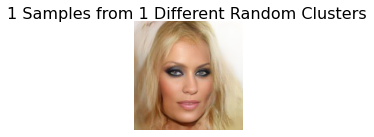


--- 4개(2x2) 이미지 그리드 생성 ---
그리드 이미지 저장 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/sampling_results/grid_samples/grid_4_samples.png


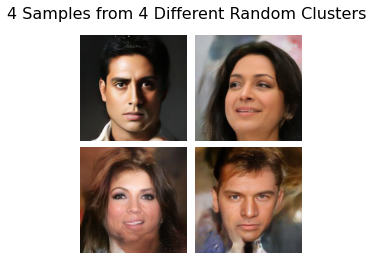


--- 16개(4x4) 이미지 그리드 생성 ---
그리드 이미지 저장 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/sampling_results/grid_samples/grid_16_samples.png


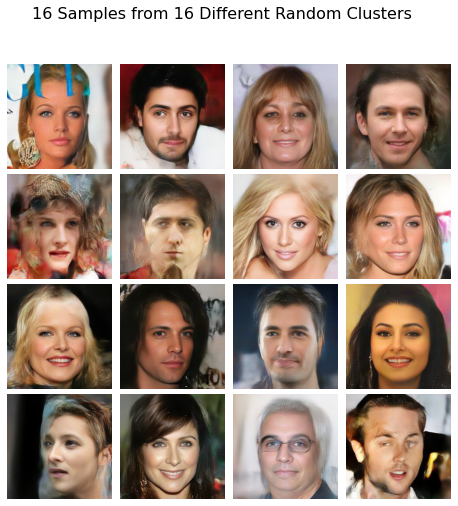


--- 64개(8x8) 이미지 그리드 생성 ---
그리드 이미지 저장 완료: /home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/sampling_results/grid_samples/grid_64_samples.png


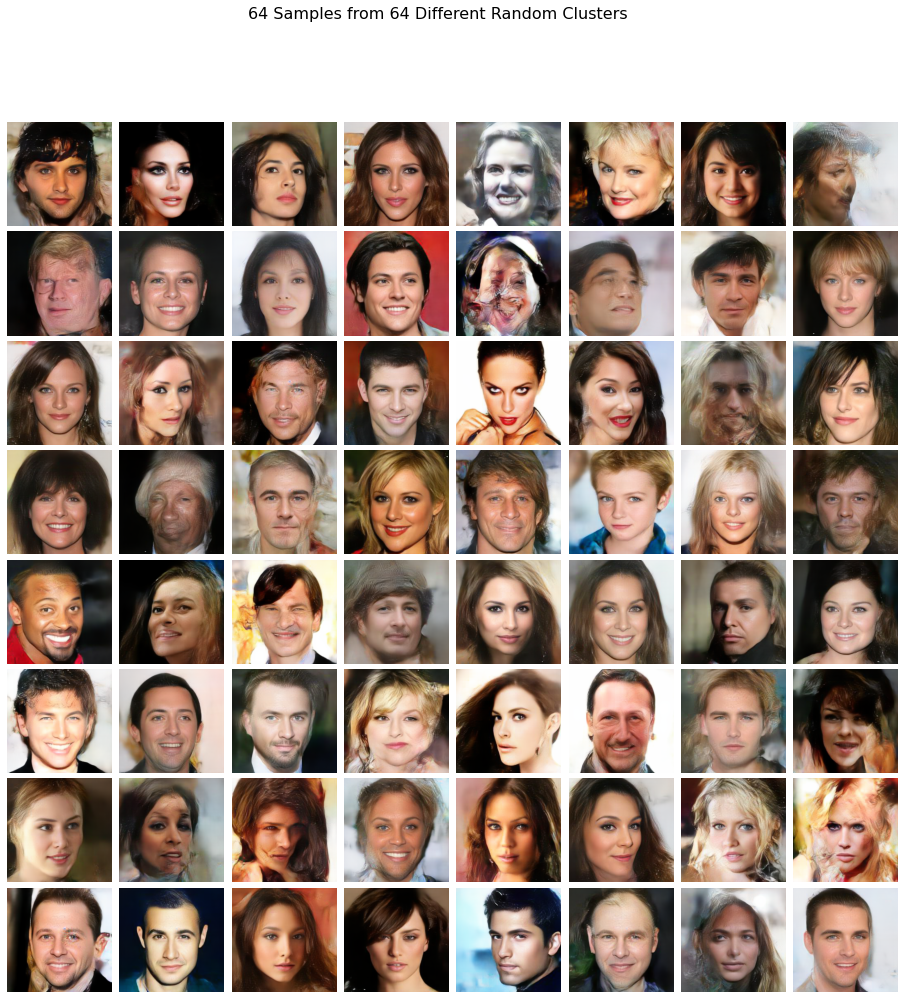

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm
import joblib
import matplotlib.pyplot as plt
import random

# ================================================================
# 1. 기본 설정 및 경로 정의
# ================================================================
print("Step 1: 기본 설정 로드")
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
DATA_DIR = '/home/nas/data/KYM/Diffusion model/CelebA Autoencoder/archive/celeba_hq_256/'

# --- 모델 경로 ---
AE_CHECKPOINT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/'
ENCODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'encoder_superdeep_best.pth')
DECODER_PATH = os.path.join(AE_CHECKPOINT_DIR, 'decoder_superdeep_best.pth')

GMM_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/checkpoints/'
N_CLUSTERS = 2500
GMM_PATH = os.path.join(GMM_DIR, f'gmm_{N_CLUSTERS}_superdeep_full.pkl') # Full GMM 모델 사용

# --- 결과 저장 경로 ---
OUTPUT_DIR = '/home/nas/data/KYM/Diffusion model/논문실험2/superdeep_ae/sampling_results/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'cluster_comparisons'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'grid_samples'), exist_ok=True)

# ================================================================
# 2. 필요한 클래스 및 함수 정의
# ================================================================
print("Step 2: 모델 클래스 및 함수 정의")
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels), nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.silu = nn.SiLU()
    def forward(self, x): return self.silu(self.block(x) + self.shortcut(x))

class EncoderSuperDeep(nn.Module):
    def __init__(self, in_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, base_channels*2, 3, 2, 1), ResBlock(base_channels*2, base_channels*2),
            nn.Conv2d(base_channels*2, base_channels*4, 3, 2, 1), ResBlock(base_channels*4, base_channels*4),
            nn.Conv2d(base_channels*4, base_channels*8, 3, 2, 1), ResBlock(base_channels*8, base_channels*8),
            nn.Conv2d(base_channels*8, base_channels*16, 3, 2, 1), ResBlock(base_channels*16, base_channels*16),
            nn.Conv2d(base_channels*16, 2 * latent_channels, 3, 1, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)
        return mu, log_var

class DecoderSuperDeep(nn.Module):
    def __init__(self, out_channels=3, base_channels=128, latent_channels=1):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels, base_channels*16, 3, 1, 1), ResBlock(base_channels*16, base_channels*16),
            nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*16, base_channels*8, 3, 1, 1),
            ResBlock(base_channels*8, base_channels*8), nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels*8, base_channels*4, 3, 1, 1), ResBlock(base_channels*4, base_channels*4),
            nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(base_channels*4, base_channels*2, 3, 1, 1),
            ResBlock(base_channels*2, base_channels*2), nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels*2, base_channels, 3, 1, 1), ResBlock(base_channels, base_channels),
            nn.Conv2d(base_channels, out_channels, 3, 1, 1), nn.Tanh()
        )
    def forward(self, z): return self.decoder(z)

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, idx

def denormalize(tensor):
    return (tensor.clamp(-1, 1) * 0.5) + 0.5

# ================================================================
# 3. 메인 실행 파이프라인
# ================================================================
def main():
    # --- 모델 및 데이터 로드 ---
    print("\nStep 3.1: 모델 및 데이터 로드")
    encoder = EncoderSuperDeep().to(DEVICE)
    decoder = DecoderSuperDeep().to(DEVICE)
    encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=DEVICE))
    decoder.load_state_dict(torch.load(DECODER_PATH, map_location=DEVICE))
    encoder.eval(); decoder.eval()
    print("Autoencoder 모델 로드 완료.")

    gmm_params = joblib.load(GMM_PATH)
    gmm_means = torch.from_numpy(gmm_params['means']).float().to(DEVICE)
    gmm_covs = torch.from_numpy(gmm_params['covariances']).float().to(DEVICE)
    print("GMM 모델 로드 완료.")

    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
    train_dataset_full = CustomImageDataset(DATA_DIR, transform) # 전체 데이터셋 객체
    train_dataset = Subset(train_dataset_full, list(range(20000)))
    loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

    # --- 잠재 벡터 추출 및 클러스터 할당 ---
    print("\nStep 3.2: 잠재 벡터 추출 및 클러스터 할당")
    all_mu_vectors_flat = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="평균 벡터(mu) 추출 중"):
            imgs = imgs.to(DEVICE)
            mu, _ = encoder(imgs)
            all_mu_vectors_flat.append(mu.view(mu.size(0), -1).cpu())
    
    all_mu_vectors_flat = torch.cat(all_mu_vectors_flat, dim=0).to(DEVICE)
    print("잠재벡터 shape : ", all_mu_vectors_flat.shape)

    log_probs = []
    for k in tqdm(range(N_CLUSTERS), desc="클러스터 할당 중"):
        dist = torch.distributions.MultivariateNormal(gmm_means[k], gmm_covs[k])
        log_probs.append(dist.log_prob(all_mu_vectors_flat))
    
    assignments = torch.argmax(torch.stack(log_probs, dim=1), dim=1)

    # --- 1. 클러스터 분석 ---
    print("\n--- 요청 1: 클러스터 분석 결과 ---")
    cluster_counts = torch.bincount(assignments, minlength=N_CLUSTERS)
    active_clusters_indices = torch.where(cluster_counts >= 2)[0]
    print(f"총 {N_CLUSTERS}개의 클러스터 중, 2개 이상의 데이터가 할당된 클러스터 수: {len(active_clusters_indices)}개")

    # --- 2. 클러스터별 샘플링 및 시각화 (20회 반복) ---
    print("\n--- 요청 2: 클러스터별 샘플링 및 시각화 (랜덤 20개 클러스터) ---")
    selected_clusters = random.sample(active_clusters_indices.tolist(), min(20, len(active_clusters_indices)))

    for cluster_idx in tqdm(selected_clusters, desc="클러스터별 비교 이미지 생성 중"):
        original_img_indices = torch.where(assignments == cluster_idx)[0]
        num_assigned = len(original_img_indices)

        mean = gmm_means[cluster_idx]
        cov = gmm_covs[cluster_idx]
        dist = torch.distributions.MultivariateNormal(mean, cov)
        sampled_latents = dist.sample((10,)).view(10, 1, 16, 16)

        with torch.no_grad():
            generated_imgs = decoder(sampled_latents.to(DEVICE)).cpu()

        fig, axes = plt.subplots(2, 10, figsize=(20, 4.5))
        fig.suptitle(f'Cluster #{cluster_idx} (Assigned: {num_assigned})', fontsize=16)
        
        for i in range(10):
            if i < num_assigned:
                original_img, _ = train_dataset[original_img_indices[i].item()]
                axes[0, i].imshow(denormalize(original_img).permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(denormalize(generated_imgs[i]).permute(1, 2, 0))
            axes[1, i].axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(OUTPUT_DIR, f'cluster_comparisons/cluster_{cluster_idx}_comparison.png'))
        plt.close(fig)

    print("클러스터별 비교 이미지 저장 완료.")

    # --- 3 & 4. 그리드 샘플링 및 시각화 ---
    print("\n--- 요청 3 & 4: 그리드 샘플링 및 시각화/저장 ---")
    sample_counts = [1, 4, 16, 64]
    for count in sample_counts:
        grid_size = int(np.sqrt(count))
        print(f"\n--- {count}개({grid_size}x{grid_size}) 이미지 그리드 생성 ---")

        if len(active_clusters_indices) < count:
            print(f"경고: 활성 클러스터 수({len(active_clusters_indices)}개)가 샘플링할 개수({count}개)보다 적어 건너뜁니다.")
            continue
        
        clusters_to_sample_from = random.sample(active_clusters_indices.tolist(), count)
        latents_list = []
        for cluster_idx in clusters_to_sample_from:
            dist = torch.distributions.MultivariateNormal(gmm_means[cluster_idx], gmm_covs[cluster_idx])
            latents_list.append(dist.sample((1,)))
            
        latents = torch.cat(latents_list, dim=0).view(count, 1, 16, 16)
        
        with torch.no_grad():
            images = decoder(latents.to(DEVICE)).cpu()
        images = denormalize(images)
        
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        fig.suptitle(f"{count} Samples from {count} Different Random Clusters", fontsize=16)
        
        img_iter = iter(images)
        if count == 1:
            axes.imshow(next(img_iter).permute(1, 2, 0)); axes.axis('off')
        else:
            for ax in axes.flat:
                ax.imshow(next(img_iter).permute(1, 2, 0)); ax.axis('off')

        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        
        save_path = os.path.join(OUTPUT_DIR, f'grid_samples/grid_{count}_samples.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"그리드 이미지 저장 완료: {save_path}")
        plt.show()

if __name__ == '__main__':
    main()